## Stock Price Prediction With LSTMs

#### Time Series Prediction

We will be using a Multi Layer LSTM network for predicting the Average Closing Price on a particular day from the data of the past 60 days.

In [82]:
# import necessary libraries
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import seaborn as sns

In [4]:
stock_data = pd.read_csv('Prepared_Data.csv')
stock_data.head()

,Date,Volume,Sentiment,y
0,2008-08-08,212830000,0,11734.320312
1,2008-08-11,183190000,1,11782.349609
2,2008-08-12,173590000,0,11642.469727
3,2008-08-13,182550000,0,11532.959961
4,2008-08-14,159790000,1,11615.929688


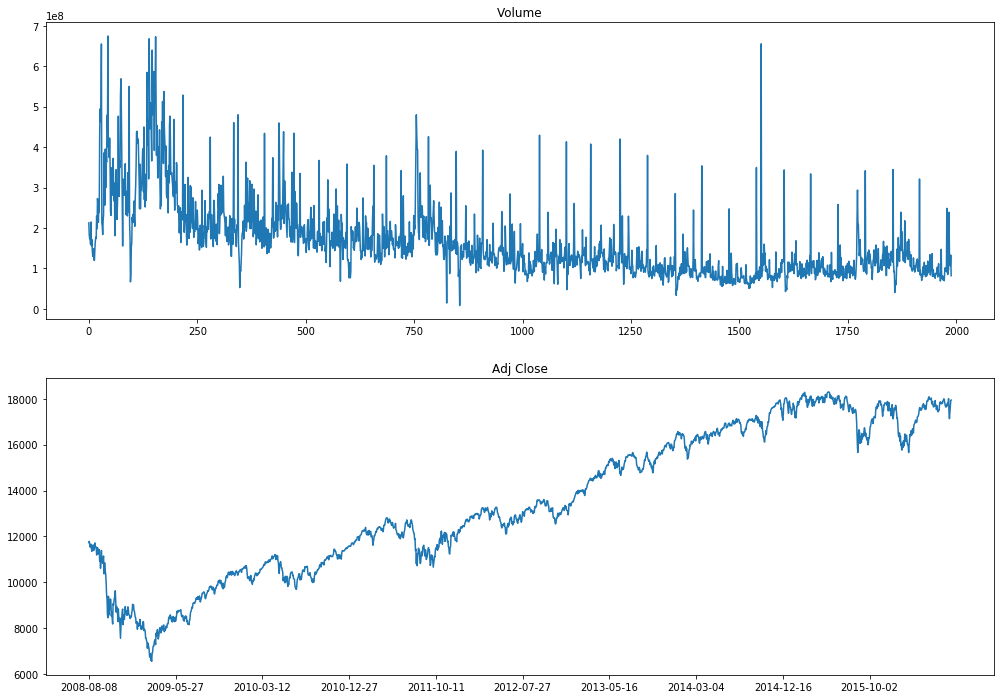

In [51]:
# visualization of the variation of the different features over time
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(17,12))
ax1.plot(stock_data['Volume'])
plt.xticks(range(0,stock_data.shape[0],200),stock_data['Date'].loc[::200]) 
#ax.set_xticklabels([1,4,5], fontsize=12)
#ax1.xticks.set_text(range(0,stock_data.shape[0],500),stock_data['Date'].loc[::500],rotation=45)
ax1.title.set_text('Volume')
ax2.title.set_text('Adj Close')
ax2.plot(stock_data['y'])

In [36]:
# Scaling data in the range of 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data.set_index('Date'))

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [60]:
# splitting data into train and test
stock_data_temp = pd.DataFrame(scaled_data,columns=stock_data.set_index('Date').columns)
stock_data_temp['Adj Close'] = stock_data_temp['y'] # duplicate closing price column to help in LSTM data preparation
stock_train = stock_data_temp[stock_data['Date'] < '2015-01-01']
stock_test = stock_data_temp[stock_data['Date'] > '2014-12-31']

In [61]:
# cross check if the data has been scaled
stock_data_temp.describe()

,Volume,Sentiment,y,Adj Close
count,1989.000000,1989.000000,1989.000000,1989.000000
mean,0.231656,0.537456,0.587827,0.587827
std,0.140918,0.498720,0.267226,0.267226
min,0.000000,0.000000,0.000000,0.000000
25%,0.137417,0.000000,0.371118,0.371118
50%,0.190185,1.000000,0.550645,0.550645
75%,0.276350,1.000000,0.844120,0.844120
max,1.000000,1.000000,1.000000,1.000000


## Univariate LSTM

------

### Adj Closing Price alone will be considered for the prediction task

The data of closing price for all the days will be used to convert it into a supervised learning problem. If the closing price for day 'n' needs to be predicted, then the features for it would be the closing prices of the last 60 days.

In [122]:
# setting parameter values for the preparing the data for Univariate LSTM
input_step_uni = 60

In [123]:
# preparing training data by including time step
stock_x_train = []
stock_y_train = []
for i in range(60,len(stock_train)):
    stock_x_train.append(stock_data_temp.iloc[i-input_step_uni:i,-1])
    stock_y_train.append(stock_data_temp.iloc[i,-1])
    
stock_x_train, stock_y_train = np.array(stock_x_train), np.array(stock_y_train)
# reshaping into a 3D array
stock_x_train = np.reshape(stock_x_train, (stock_x_train.shape[0],stock_x_train.shape[1],1))

In [124]:
# preparing test data
inputs = stock_data_temp[len(stock_data_temp) - len(stock_test) - 60:]
inputs = inputs['Adj Close']

stock_x_test = []
for i in range(input_step_uni,inputs.shape[0]):
    stock_x_test.append(inputs[i-60:i])
    
stock_x_test = np.array(stock_x_test)

# reshaping into a 3D array
stock_x_test = np.reshape(stock_x_test, (stock_x_test.shape[0],stock_x_test.shape[1],1))

In [125]:
# defining LSTM univariate model
model_uni = Sequential()
model_uni.add(LSTM(units=50, return_sequences=True, input_shape=(stock_x_train.shape[1],1)))
model_uni.add(LSTM(units=50))
model_uni.add(Dense(1))

# compiling model
model_uni.compile(loss='mean_squared_error', optimizer='adam')
model_uni.fit(stock_x_train, stock_y_train, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
 - 70s - loss: 0.0022


In [126]:
# predicting closing prices
closing_price = model_uni.predict(stock_x_test)

Mean Absolute Error (normalised data) :  0.021325282705370978


C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


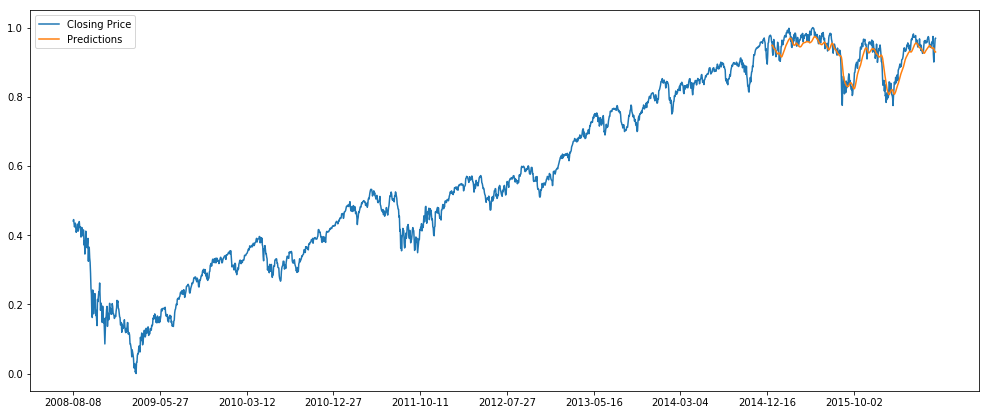

In [127]:
# computing mean absolute error
print('Mean Absolute Error (normalised data) : ', mean_absolute_error(stock_test['y'],closing_price))
stock_test['Prediction_uni'] = closing_price
# visualizing results
plt.figure(figsize=(17,7))
plt.xticks(range(0,stock_data.shape[0],200),stock_data['Date'].loc[::200])
plt.plot(stock_data_temp['y'], label ='Closing Price')
plt.plot(stock_test['Prediction_uni'], label = 'Predictions')
plt.legend()

## Multivariate LSTM

-----

### Reshaping Input Data for Feeding to Multivariate LSTM Network

For multivariate analysis along with the closing price, we will be considering the sentiment and volume data as well.
In this case the input data is reshaped into a three dimensional array consisting of the following dimensions:

- Samples : One sequence is one sample. A batch is comprised of one or more samples.
- Time Steps : One time step is one point of observation in the sample.
- Features : One feature is one observation at a time step.

In [62]:
 def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
      # find the end of this pattern
        end_ix = i + n_steps_in 
        out_end_ix = end_ix + n_steps_out
      # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
          # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In the context of our problem, we will considering the data of immediate past 60 data points (days) to predict the closing price 1 day into the future. 

In [63]:
# setting parameter values for the preparing the data for Multivariate LSTM
input_steps = 60
output_steps = 1

In [64]:
# reshaping train and test data
X_df_train, y_df_train = split_sequences(np.array(stock_train), input_steps, output_steps)
X_test_df, y_test_df = split_sequences(np.array(stock_data_temp[stock_train.shape[0]-input_steps:]),input_steps,output_steps)

In [65]:
# building LSTM neural network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, activation='relu', input_shape=(input_steps,X_df_train.shape[-1])))
model.add(LSTM(units=50,activation='relu'))
model.add(Dense(1))

In [66]:
# compiling model
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_df_train, y_df_train, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
 - 95s - loss: 0.0037


In [67]:
# predicting closing price
y = model.predict(X_test_df)

Mean Absolute Error (normalised data) :  0.027585215207713842


C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


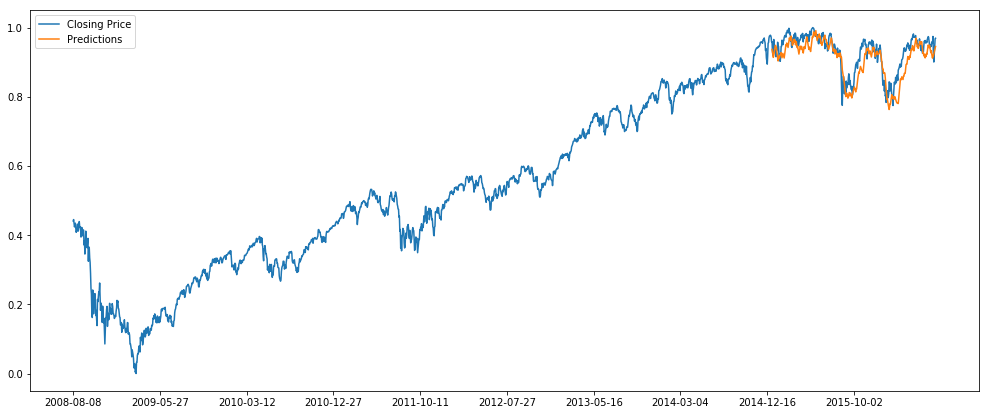

In [116]:
# computing mean absolute error
print('Mean Absolute Error (normalised data) : ', mean_absolute_error(stock_test['y'],y))
# visualizing results
stock_test['predictions_multi'] = y
plt.figure(figsize=(17,7))
plt.xticks(range(0,stock_data.shape[0],200),stock_data['Date'].loc[::200]) 
plt.plot(stock_data_temp['y'],label = 'Closing Price')
plt.plot(stock_test['predictions_multi'],label = 'Predictions')
plt.legend()